**Importing Libraries**

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as v2
import torchvision.transforms as transform
from torch.utils.data import DataLoader
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

import cv2

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device is {device}")

Device is cuda


**Preparing dataset(CIFAR-10)**

In this implementation of ResNet, we have used the CIFAR-10 dataset, as it provides a balanced trade-off between complexity and computational efficiency. Each image in CIFAR-10 has a resolution of 32 × 32 (H × W), making it suitable for experimentation and model implementation.

The primary focus of this implementation is on the architecture and design of ResNet, rather than computational load analysis. This allows for a deeper understanding of ResNet’s core principles, such as residual learning and skip connections, without being constrained by hardware limitations.

In [4]:
batch_size = 128        #->Batch size of 128 helps model converge faster
transform_fn = transform.Compose([transform.RandomCrop(32, padding=4),      #->Applies rando crop of 32 x 32 on image with padding 4
                                transform.RandomHorizontalFlip(p=0.5),      #->Randomly flips an image horizontally with probability 0.5
                                transform.ToTensor(),                       #->Converts PIL images to Tensor, hence normalizing pixel values
                                transform.Normalize(mean=[.4, .4, .4], std=[.4, .4, .4])])  #->Normalizes further 

training_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_fn)
testing_data = torchvision.datasets.CIFAR10(root='./Test_Data', train=False, download=True, transform=transform_fn)

Data_test = DataLoader(testing_data, batch_size=batch_size  , shuffle=True, num_workers=4, pin_memory=True)
Data_train = DataLoader(training_data, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.25].


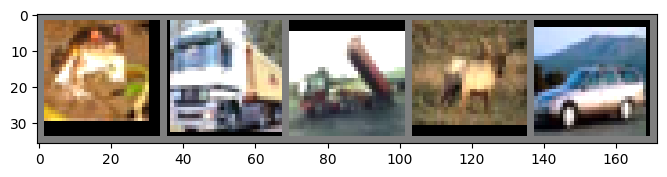

frog truck truck deer car 

In [5]:
def show_imgs(img):
    # Un-Normalizing Images since they will come normalize
    img = img/2 + 0.5
    #Converting Images to Numpy Array because 'matplotlib.pyplot.imshow' expects images to be array(numpy)
    img = img.numpy()
    #Transposing Images to Numpy Array because 'matplotlib.pyplot.imshow' expects images to be in (H,W,C) format
    img = np.transpose(img, (1, 2, 0))
    #Deciding the plot area
    plt.figure(figsize=(8,8))
    #Plotting images
    plt.imshow(img)
    plt.show()
#Making an iterable object of Training data
dataiter = iter(Data_train)
#Getting random images and their respective labels
img, label = next(dataiter)
#Selecting the first 5 images and labels
img, label = img[:5], label[:5]
#Calling the function defined above
show_imgs(torchvision.utils.make_grid(img))
for i in range(len(label)):
    print(classes[label[i]], end=' ')

In [6]:
class Block(nn.Module):
    def __init__(self,         #->Instance of Class
                in_channels,   #->No. of input channels into this block of 2 conv. layers
                out_channels,  #->No. of output channels from this block of 2 conv. layers
                k,             #->Kernel Size to be used
                downsample):   #->If the input must be downsampled ie Height/2, and width/2, channels * 2 (Helps for adding identity)
        
        super().__init__()
        self.k = k
        self.in_channels = in_channels
        self.out_channels = out_channels
        if not downsample:
            self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=k, stride=1, padding='same')
        else:
            self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=k,stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=k, padding='same')
        self.relu = nn.ReLU()
        self.downsample = downsample
        self.downsample_layer = nn.Conv2d(in_channels=in_channels, out_channels=self.out_channels, kernel_size=k, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.bn_out = nn.BatchNorm2d(out_channels)
    
    def forward(self, X):
        identity = X
        X = self.relu(self.bn1(self.conv1(X)))
        if self.downsample:
            identity = self.downsample_layer(identity)
        X = self.bn2(self.conv2(X))
        X+=identity
        return self.relu(X)

In [7]:
class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, bottleneck_ch, out_channels, k, downsample):
        super().__init__()
        self.k = k
        self.in_channels = in_channels
        self.out_channels = out_channels
        if not downsample:
            self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=bottleneck_ch, kernel_size=1, padding='same')
        else:
            self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=bottleneck_ch, kernel_size=1, stride=2)
        self.conv2 = nn.Conv2d(in_channels=bottleneck_ch, out_channels=bottleneck_ch, kernel_size=k, padding='same')
        self.conv3 = nn.Conv2d(in_channels=bottleneck_ch, out_channels=out_channels, kernel_size=1, padding='same')
        self.relu = nn.ReLU()
        self.downsample = downsample
        self.downsample_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=k, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(bottleneck_ch)
        self.bn2 = nn.BatchNorm2d(bottleneck_ch)
        self.bn3 = nn.BatchNorm2d(out_channels)
    
    def forward(self, X):
        identity = X
        X = self.relu(self.bn1(self.conv1(X)))
        x = self.relu(self.bn2(self.conv2(X)))
        if self.downsample:
            # print("donsampled")
            identity = self.downsample_layer(identity)
            identity = self.relu(identity)
        X = self.bn3(self.conv3(X))
        # print(X.shape)
        # print(identity.shape)
        X+=identity
        return self.relu(X)

In [8]:
# test_block1 = BottleneckBlock(3,64,64,3,True).to(device)
# test_block2 = BottleneckBlock(64,64,128,3,True).to(device)
# print(img.shape)
# test_block2(test_block1(img.to(device)))

In [9]:
class Layer(nn.Module):
    def __init__(self, no_blocks, in_channels, out_channels, k, downsample : bool, bottleneck : bool):
        super().__init__()
        self.layer_list = nn.ModuleList([])
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.no_blocks = no_blocks
        self.k = k
        self.downsample = downsample
        self.bottleneck = bottleneck
        if self.bottleneck == False:
            self.make_layer()
        else:
            self.make_bottleneck_layer()
    
    def make_layer(self):
        for i in range(self.no_blocks):
            if i == 0:
                self.layer_list.append(Block(self.in_channels, self.out_channels, self.k, self.downsample))
            else:
                self.layer_list.append(Block(self.out_channels, self.out_channels, self.k, False))
            
    def make_bottleneck_layer(self):
        for i in range(self.no_blocks):
            if self.in_channels == 64 and i==0:
                self.layer_list.append(BottleneckBlock(self.in_channels, self.in_channels, self.out_channels, self.k, self.downsample))
            elif self.in_channels == 64 and i!=0:
                self.layer_list.append(BottleneckBlock(self.out_channels, self.in_channels, self.out_channels, self.k, False))
            elif i==0:
                self.layer_list.append(BottleneckBlock(self.in_channels, self.in_channels//2, self.out_channels, self.k, self.downsample))
            else:
                self.layer_list.append(BottleneckBlock(self.out_channels, self.in_channels//2, self.out_channels, self.k, False))
    
    def forward(self, X):
        for i in  self.layer_list:
            X = i(X)
        return X

In [10]:
class ResNet(nn.Module):
    def __init__(self, no_blocks : list, in_ch : list, out_ch:list, bottleneck_blk : bool):
        super().__init__()
        self.downsample = True if bottleneck_blk else False
        self.layer_1 = Layer(no_blocks[0], in_ch[0], out_ch[0], 3, self.downsample, bottleneck_blk)
        self.layer_2 = Layer(no_blocks[1], in_ch[1], out_ch[1], 3, True, bottleneck_blk)
        self.layer_3 = Layer(no_blocks[2], in_ch[2], out_ch[2], 3, True, bottleneck_blk)
        self.layer_4 = Layer(no_blocks[3], in_ch[3], out_ch[3], 3, True, bottleneck_blk)
        if bottleneck_blk:
            self.conv_init = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding='same')
        else:
            self.conv_init = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.max_pool = nn.MaxPool2d(kernel_size=3, padding=1, stride=1)
        self.avg_pool = nn.AdaptiveAvgPool2d((2, 2))
        self.fc1 = nn.Linear(in_features=2 * 2* out_ch[len(out_ch) - 1], out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=10)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()


    def forward(self, X):
        X = self.conv_init(X)
        # print(f"After initial conv layer X shape is {X.shape}")
        X = self.max_pool(X)
        # print(f"After initial max pool layer X shape is {X.shape}")
        X = self.layer_1(X)
        # print(f"After conv1 layer X shape is {X.shape}")
        X = self.layer_2(X)
        # print(f"After conv2 layer X shape is {X.shape}")
        X = self.layer_3(X)
        # print(f"After conv3 layer X shape is {X.shape}")
        X = self.layer_4(X)
        # print(f"After conv4 layer X shape is {X.shape}")
        # X = self.avg_pool(X)
        X = torch.flatten(X, start_dim=1)
        X = self.dropout(self.relu(self.fc1(X)))
        X = self.fc2(X)
        return X

In [11]:
torch.manual_seed(42)

#Configuration for 18-layer ResNet
no_blocks_18 = [2, 2, 2, 2]
in_ch_18 = [64, 64, 128, 256]
out_ch_18 = [64, 128, 256, 512]

#Configuration for 34-layer ResNet
no_blocks_34 = [3, 4, 6, 3]
in_ch_34 = [64, 64, 128, 256]
out_ch_34 = [64, 128, 256, 512]

#Configuration for 50-layer ResNet
no_blocks_50 = [3, 4, 6, 3]
in_ch_50 = [64, 256, 512, 1024]
out_ch_50 = [256, 512, 1024, 2048]

#Instantiating ResNets
ResNet18 = ResNet(no_blocks_18, in_ch_18, out_ch_18, False).to(device)
ResNet34 = ResNet(no_blocks_34, in_ch_34, out_ch_34, False).to(device)
ResNet50 = ResNet(no_blocks_50, in_ch_50, out_ch_50, True).to(device)

In [12]:
def check(model, device):
    '''This function checks if the model created have right flow of channels and activations ie
    input dimensions and also check for errors'''
    
    #Creating Random img type tensor
    img = torch.rand(1,3,32,32).to(device)
    with torch.no_grad():
        model(img)
    
check(ResNet18, device)
check(ResNet34, device)
check(ResNet50, device)

In [13]:
def accuracy_step(img, label, model):
    model.eval()
    y_pred = model(img.to(device))
    y_pred = nn.functional.softmax(y_pred, dim=1)
    y_pred = torch.argmax(y_pred, dim=1).to('cpu')
    y_pred = y_pred.numpy()
    label = (label.to('cpu')).numpy()
    return accuracy_score(y_pred, label)

In [14]:
def compile_model(model):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01, momentum=0.9)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.01)
    return loss_fn, optimizer, lr_scheduler

In [15]:
def training_loop(epochs, Data_train, device, model, loss_fn, optimizer, lr_scheduler):
    epoch_list = []
    loss_list = []
    acc_list = []
    
    for epoch in range(epochs):
        
        print(epoch+1, f'/{epochs}',end=' ')
        
        for idx, (imgs, labels) in enumerate(Data_train):
            
            print('.', end='')
            
            model.train()
            
            img, labels = (imgs, labels)
            
            img = img.to(device)
            labels = labels.to(device)
            
            y_pred = model(img).to(device)
            
            loss = loss_fn(y_pred, labels)
            
            if epoch%2==0:
                epoch_list.append(epoch)
                loss_list.append(float(loss))
                acc_list.append(accuracy_step(img, labels, model))
            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
            
            if idx==0:
                loss_print = float(loss)
        
        print(f"Loss : {loss_print}")
        
        # lr_scheduler.step()
    
    return epoch_list, loss_list, acc_list

1 /20 .......................................................................................................................................................................................................................................................................................................................................................................................................Loss : 2.3461978435516357
2 /20 .......................................................................................................................................................................................................................................................................................................................................................................................................Loss : 1.3005315065383911
3 /20 ....................................................................................................................................................

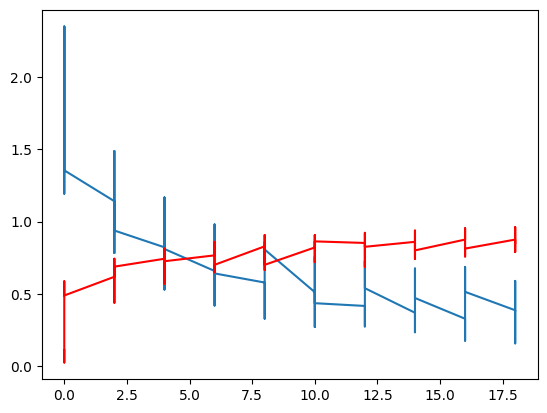

In [16]:
epochs = 20
loss_fn, optimizer, lr_scheduler = compile_model(ResNet18)
epoch_list, loss_list, acc_training = training_loop(epochs, Data_train, device, ResNet18, loss_fn, optimizer, lr_scheduler)
plt.plot(epoch_list, loss_list)
plt.plot(epoch_list, acc_training, color='red')

In [31]:
def accuracy(data, data_type, model):
    acc = 0
    for idx, (img, label) in enumerate(data):
        model.eval()
        y_pred = model(img.to(device))
        y_pred = nn.functional.softmax(y_pred, dim=1)
        y_pred = torch.argmax(y_pred, dim=1).to('cpu')
        y_pred = y_pred.numpy()
        label = (label.to('cpu')).numpy()
        acc+= accuracy_score(y_pred, label)
    return acc/idx

In [33]:
accuracy_train = accuracy(Data_train, 'training', ResNet18)
accuracy_test = accuracy(Data_test, 'testing', ResNet18)
print(f"Average Training accuracy (ResNet-18) is {accuracy_train}")
print(f"Average Testing accuracy (ResNet-18) is {accuracy_test}")

Average Training accuracy (ResNet-18) is 0.8908814102564103
Average Testing accuracy (ResNet-18) is 0.8486578525641025


In [19]:
def predict(img, model):
    with torch.no_grad():
        y_pred = model(img.to(device))
    y_pred = nn.functional.softmax(y_pred, dim=1)
    print(y_pred)
    y_pred = torch.argmax(y_pred, dim=1)
    print(classes[int(y_pred)], int(y_pred))

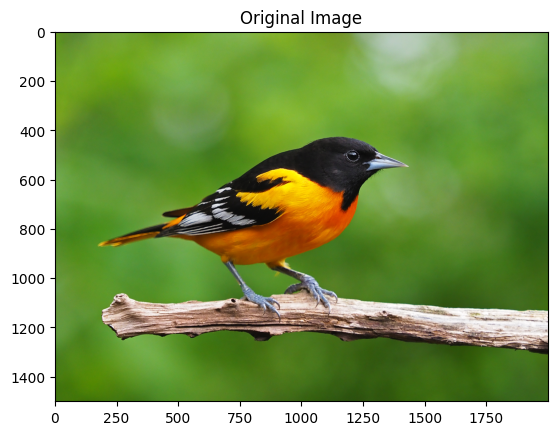

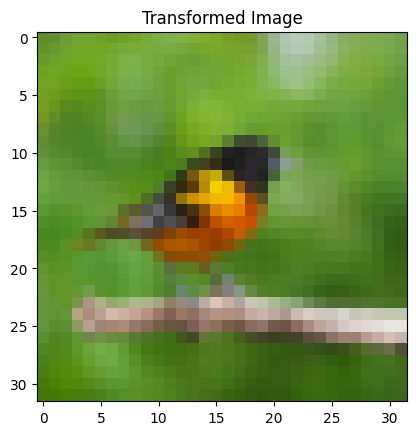

tensor([[5.1914e-05, 2.1240e-06, 6.7426e-01, 4.7241e-03, 3.1833e-01, 1.0820e-03,
         1.2149e-03, 3.0011e-04, 1.4778e-05, 2.0227e-05]], device='cuda:0')
bird 2


In [20]:
from PIL import Image
img = Image.open('birddddd.webp')

# Display original image
plt.imshow(img)
plt.title("Original Image")
plt.show()

transform_fn_testing = transform.Compose([
    transform.Resize((32, 32)),  # Resize to expected input size
    transform.ToTensor(),  # Convert to tensor (automatically normalizes to [0,1])
    # transform.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Apply transformations (Assuming transform_fn returns a PyTorch tensor)
img = transform_fn_testing(img)

# Display transformed image
plt.imshow(img.permute(1, 2, 0).numpy())  # Convert CHW → HWC for visualization
plt.title("Transformed Image")
plt.show()

# Normalize and add batch dimension
img = img.unsqueeze(0).float() # Shape: (1, C, H, W)

# Make prediction
output = predict(img, ResNet18)

In [24]:
torch.save(ResNet18.state_dict(), 'resnet18_cifar10_trained_model_weights.pth')

In [37]:
resnet = ResNet(no_blocks_34, in_ch_34, out_ch_34, False).to(device)
resnet.load_state_dict(torch.load('resnet34_cifar10_trained_model_weights.pth', weights_only = True))
resnet.eval()
print(f"Average Training accuracy (ResNet-34) is {accuracy(Data_train, 'training', resnet)}")
print(f"Average Testing accuracy (ResNet-34) is {accuracy(Data_test, 'testing', resnet)}")

Average Training accuracy (ResNet-34) is 0.8763862179487178
Average Testing accuracy (ResNet-34) is 0.8378405448717948
